<a href="https://colab.research.google.com/github/Keval1998/Projects_AIP_PRML/blob/master/LicencePlateProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np

In [ ]:
# #3.jpg
# #2.jpg
PATH = '//content//drive//My Drive//aipProject//imgs//2.jpg'
# img = cv2.imread(PATH,0)
# apply(img)

In [ ]:
def extract_plate(img): # the function detects and perfors blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('//content//drive//My Drive//aipProject//indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)
 
	for (x,y,w,h) in plate_rect:
		#x,y coordinates
		#w,h height,width
		a,b = (int(0.02*img.shape[0]), int(0.025*img.shape[1])) #parameter tuning
		plate = plate_img[y-a:y+h+a, x-b:x+w+b]
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)
        
	return plate_img, plate # returning the processed image

In [ ]:
 img = cv2.imread(PATH,0)
 extract_plate(img)

(array([[118, 119, 121, ..., 118, 120, 122],
        [126, 126, 126, ..., 128, 123, 120],
        [133, 133, 132, ..., 120, 120, 121],
        ...,
        [126, 126, 123, ..., 112, 113, 113],
        [126, 130, 124, ..., 112, 113, 113],
        [125, 133, 126, ..., 112, 113, 113]], dtype=uint8),
 array([[129, 128, 127, ..., 118, 127, 123],
        [133, 134, 134, ..., 121, 124, 122],
        [135, 137, 138, ..., 125, 120, 121],
        ...,
        [125, 133, 143, ..., 114, 114, 113],
        [132, 131, 131, ..., 117, 117, 117],
        [128, 131, 129, ..., 109, 107, 110]], dtype=uint8))

In [ ]:
from google.colab.patches import cv2_imshow

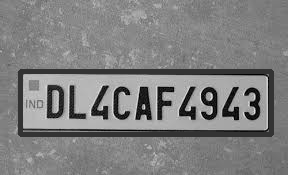

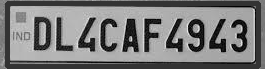

In [ ]:
img = cv2.imread(PATH,0)
p1,p2 = extract_plate(img)
cv2_imshow(p1)
cv2_imshow(p2)

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:

# Find characters in the resulting images
def segment_characters(image) :
    img = cv2.resize(image, (333, 75))

    img = np.array(img, dtype=np.uint8)

    try:
      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
      img_gray = img
    
    _, img_binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(img_binary, (3,3))
    img_dilate = cv2.dilate(img_erode, (7,7))

    LP_WIDTH = img_dilate.shape[0]
    LP_HEIGHT = img_dilate.shape[1]

    # Make borders white
    img_dilate[0:3,:] = 255
    img_dilate[:,0:3] = 255
    img_dilate[72:75,:] = 255
    img_dilate[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_dilate)

    return char_list

l = segment_characters(p2)
l = np.array(l, dtype=np.uint8)

for i in l:
  cv2_imshow(i)
  print()
cv2.waitKey(0)

-1

In [ ]:
p2.shape

(29, 137)

In [ ]:
l = find_contours([0,17,0,123],p2)
for i in l:
  cv2_imshow(i)
cv2.waitKey(0)

-1

In [ ]:
# from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
# from keras.models import Model, Sequential
# from keras.preprocessing.image import ImageDataGenerator
# from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:
# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(28, 28, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(rate=0.4))
# model.add(Flatten())
# model.add(Dense(units=128, activation='relu'))
# model.add(Dense(units=36, activation='softmax'))

In [ ]:
# i = cv2.imread('//content//drive//My Drive//aipProject//datas//data//train//class_0//class_0_10.jpg')
# i.shape

(28, 28, 3)

In [ ]:

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.05, height_shift_range=0.05)

# train_generator = train_datagen.flow_from_directory(
#         '//content//drive//My Drive//aipProject//datas//data//train',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')

# validation_generator = train_datagen.flow_from_directory(
#         '//content//drive//My Drive//aipProject//datas//data//val',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# import datetime
# import keras
      
# # import datetime
# # class stop_training_callback(keras.callbacks.Callback):
# #   def on_epoch_end(self, epoch, logs={}):
# #     if(logs.get('val_acc') > 0.992):
# #       self.model.stop_training = True
      
# # log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# batch_size = 1
# callbacks = [tensorboard_callback, stop_training_callback()]
# hist = model.fit(train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       validation_steps = validation_generator.samples // batch_size,
#       epochs = 80)#, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 293s 339ms/step - loss: 1.1195 - accuracy: 0.6806 - val_loss: 1.8690e-04 - val_accuracy: 0.8843
Epoch 2/80
864/864 [==============================] - 9s 10ms/step - loss: 0.2367 - accuracy: 0.9236 - val_loss: 2.6226e-06 - val_accuracy: 0.9352
Epoch 3/80
864/864 [==============================] - 9s 10ms/step - loss: 0.1244 - accuracy: 0.9606 - val_loss: 4.0642e-04 - val_accuracy: 0.9444
Epoch 4/80
864/864 [==============================] - 9s 10ms/step - loss: 0.1352 - accuracy: 0.9595 - val_loss: 0.0033 - val_accuracy: 0.9537
Epoch 5/80
864/864 [==============================] - 9s 10ms/step - loss: 0.1100 - accuracy: 0.9595 - val_loss: 1.2755e-05 - val_accuracy: 0.9769
Epoch 6/80
864/864 [==============================] - 9s 10ms/step - loss: 0.1078 - accuracy: 0.9653 - val_loss: 4.1345e-04 - val_accuracy: 0.9306
Epoch 7/80
864/864 [==============================] - 9s 10ms/step - loss: 0.1120 - accuracy: 0.9641 - val_loss: 0.0031

In [ ]:
import pickle
# with open('//content//drive//My Drive//aipProject//model.pickle', 'wb') as f:
#   pickle.dump(model,f)
with open('//content//drive//My Drive//aipProject//model.pickle', 'rb') as f:
  model = pickle.load(f)

Using TensorFlow backend.


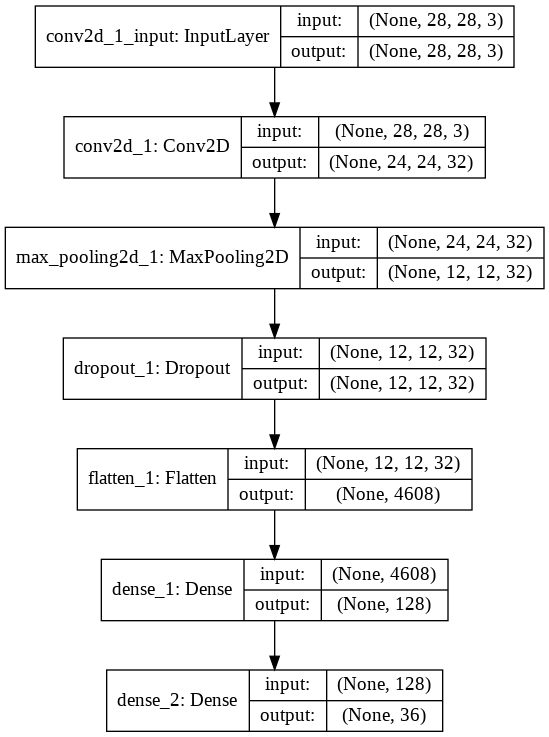

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# import pickle
# with open('//content//drive//My Drive//aipProject//model2.pickle', 'wb') as f:
#   pickle.dump(model,f)
# with open('//content//drive//My Drive//aipProject//loss.pickle', 'wb') as f:
#   pickle.dump(hist.history['loss'],f)
# with open('//content//drive//My Drive//aipProject//valloss.pickle', 'wb') as f:
#   pickle.dump(hist.history['val_loss'],f)
# with open('//content//drive//My Drive//aipProject//acc.pickle', 'wb') as f:
#   pickle.dump(hist.history['accuracy'],f)
# with open('//content//drive//My Drive//aipProject//valaccloss.pickle', 'wb') as f:
#   pickle.dump(hist.history['val_accuracy'],f)

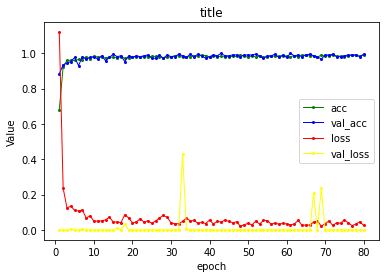

In [ ]:
import pickle
with open('//content//drive//My Drive//aipProject//loss.pickle', 'rb') as f:
  loss = pickle.load(f)
with open('//content//drive//My Drive//aipProject//valloss.pickle', 'rb') as f:
  val_loss = pickle.load(f)
with open('//content//drive//My Drive//aipProject//acc.pickle', 'rb') as f:
  accuracy = pickle.load(f)
with open('//content//drive//My Drive//aipProject//valaccloss.pickle', 'rb') as f:
  val_accuracy = pickle.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('title')

plt.plot(range(1,81),accuracy,marker='o',color='green',markerfacecolor='green',markersize=2,linewidth=1,label='acc')
plt.plot(range(1,81),val_accuracy,marker='o',color='blue',markerfacecolor='blue',markersize=2,linewidth=1,label='val_acc')
plt.plot(range(1,81),loss,marker='o',color='red',markerfacecolor='red',markersize=2,linewidth=1,label='loss')
plt.plot(range(1,81),val_loss,marker='o',color='yellow',markerfacecolor='yellow',markersize=2,linewidth=1,label='val_loss')

plt.legend()
plt.show()

In [ ]:
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

# print(show_results(l))

In [ ]:
import matplotlib.pyplot as plt
def check(l):
  plt.figure(figsize=(10,6))
  for i,ch in enumerate(l):
      img = cv2.resize(ch, (28,28))
      plt.subplot(3,4,i+1)
      plt.imshow(img,cmap='gray')
      plt.title(f'predicted: {show_results(l)[i]}')
      plt.axis('off')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
def apply(img, extract = False, plate = False, charshow = False, res = True):
  p1,p2 = extract_plate(img)
  if extract == True:
    cv2_imshow(p1)
  if plate == True:
    cv2_imshow(p2)
  l = segment_characters(p2)
  l = np.array(l, dtype=np.uint8)
  print(len(l))
  if charshow == True:
    check(l)
  if res == True:
    print(show_results(l))

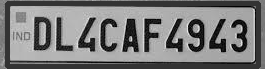

10
DL4CAF4343


In [ ]:
#%matplotlib inline  
PATH = '//content//drive//My Drive//aipProject//imgs//2.jpg'
img = cv2.imread(PATH,0)
apply(img,res=True,plate=True,charshow=False)

In [ ]:
vidPath = '//content//drive//My Drive//aipProject//imgs//Mercedes Cars Road Trip.mp4'
# vidPath = '//content//drive//My Drive//aipProject//imgs//cuban_car_collection05_preview.mp4'

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(vidPath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

1


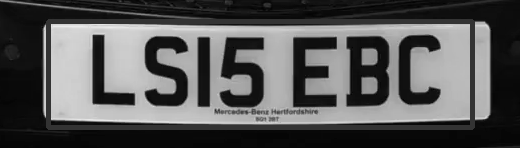

6
LS5EBC
2


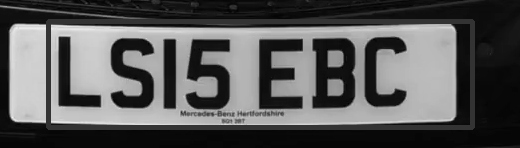

7
JLS5EBC
3


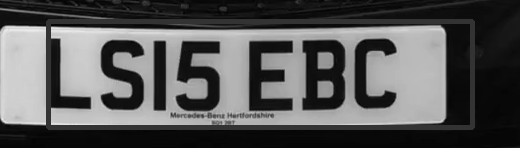

5
S5EBC
4


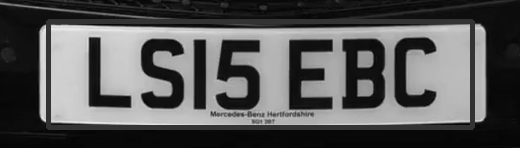

6
LS5EBC
5


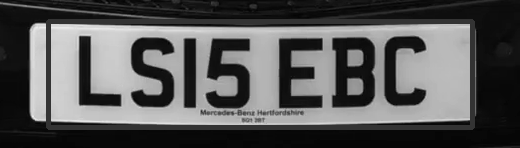

6
LS5EBC
6
7
8
9


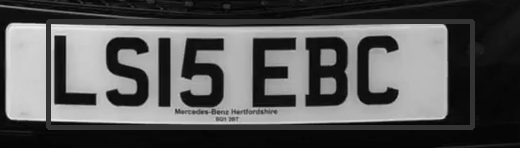

7
JLS5EBC
10
11
12
13


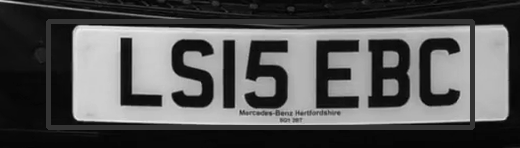

7
LS5EBCI
14


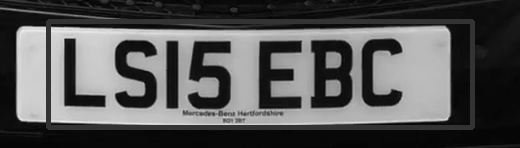

7
JLS5EBC
15
16
17


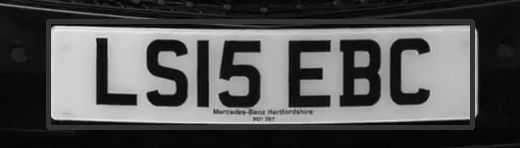

6
LS5EBC
18
19


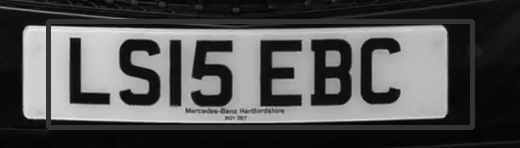

7
ILS5EBC
20


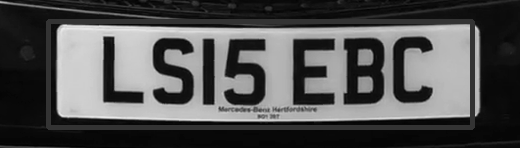

6
LS5EBC
21
22
23
24


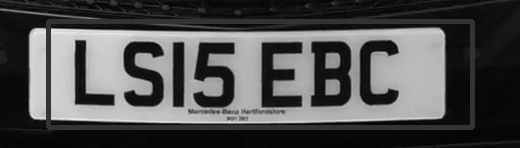

6
LS5EBC
25
26


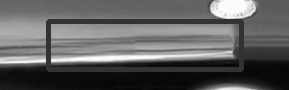

0

27
28


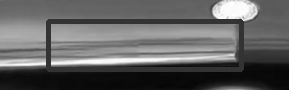

0

29


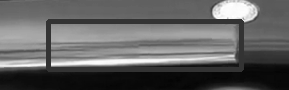

0

30


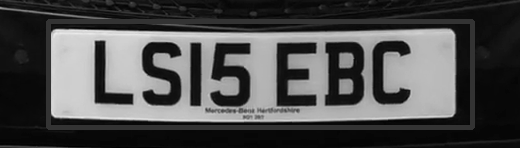

6
LS5EBC
31


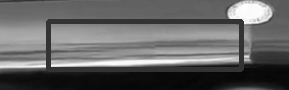

0

32


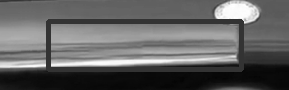

0

33
34
35


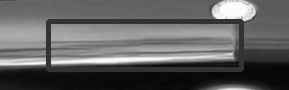

0

36
37


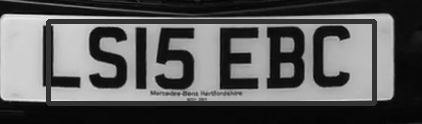

4
S5EB
38


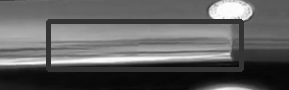

0

39
40
41


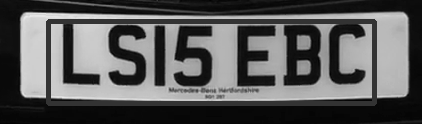

1
5
42
43
44


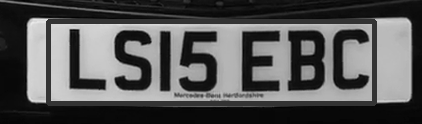

8
ILS5EBCI
45


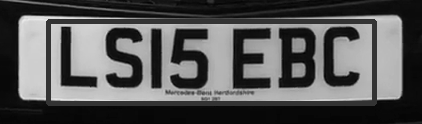

6
LS5EBC
46
47
48


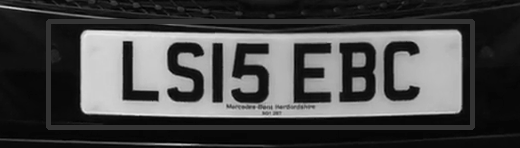

1
5
49
50


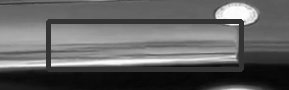

0

51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


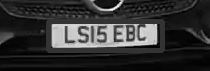

0

111


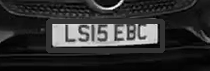

0

112


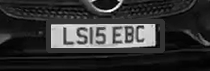

0

113


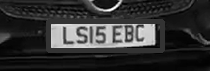

0

114


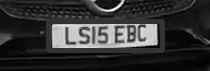

0

115
116


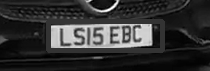

0

117
118
119
120
121
122
123


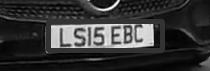

0

124


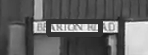

0

125


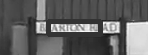

0

126


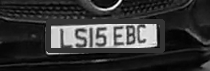

0

127


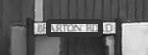

0

128


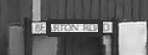

0

129


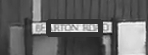

0

130
131


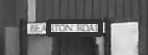

0

132


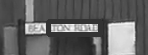

0

133
134
135


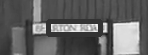

0

136


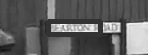

0

137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


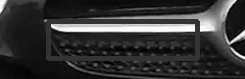

0

167
168
169
170
171
172
173
174
175
176


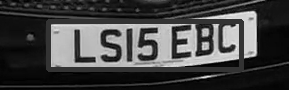

0

177
178
179
180
181


In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture(vidPath)

# print("cap  \n",cap)

count=0
while(count<20000):
    count+=1
    if count%1000==0:
      continue
    print(count)
    ret, frame = cap.read()
    if ret!=True:
      break
    # print("\n\nret\n",ret)
    # print("\n\nframe\n",frame)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # gray = cv2.rotate(gray, cv2.ROTATE_90_CLOCKWISE)
    try:
      apply(gray,plate=True,res=True)
    except:
      pass
    gray = cv2.resize(gray, (300, 200))
    # cv2_imshow(gray)
    cv2.waitKey(0)

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
import pickle
with open('//content//drive//My Drive//aipProject//Images.pickle', 'rb') as f:
  imgs = pickle.load(f)
with open('//content//drive//My Drive//aipProject//Plates.pickle', 'rb') as f:
  plts = pickle.load(f)


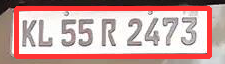

6
L5R247
10



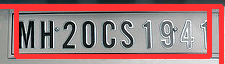

4
H20G
12



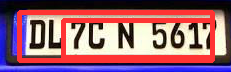

1
1
15



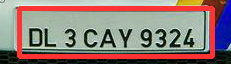

0

16



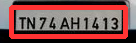

0

17



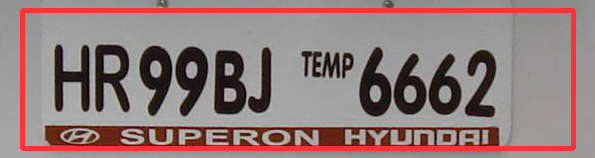

6
HR9962
19



In [ ]:
for i in range(10,20):
  try:
    apply(imgs[i],res=True,plate=True)
    print(i)
    print()
  except:
    pass

In [ ]:
path = '//content//drive//My Drive//character_14(1).png'
img = cv2.imread(path,0)
img_ = cv2.resize(img, (28,28))
img = fix_dimension(img_)
img = img.reshape(1,28,28,3)
y_ = model.predict_classes(img)
y_

array([3])